# Urban Airscape: Determinants of Air Quality in City Environments

## 1. Model overview

#### Machine Learning Regression: Predicting CO Concentration

In this notebook, we will dive into our machine learning regression model to address one of the core questions of our project. We aim to leverage insights gained from our exploratory data analysis (EDA) and use the **Principal Component Analysis (PCA)** components as features to predict the target variable **PT08.S1 (CO)**.

#### Understanding the Target Variable
**PT08.S1 (CO)** represents the concentration of carbon monoxide (CO) as measured by a specific sensor. CO is a harmful air pollutant, and its concentration can be influenced by various environmental and atmospheric factors.

#### Project Objective
The specific research question we aim to answer in this section is:

**What is the relationship between CO concentrations and other factors?**
- More specifically, we want to explore how other air pollutants and environmental variables, such as temperature and humidity, impact the concentration of **PT08.S1 (CO)**.

To achieve this, we will:
1. Use the PCA component scores as predictors in our regression model.
2. Evaluate how well these components, which summarize air pollutants and environmental conditions, explain the variations in CO levels.

This analysis will allow us to gain a deeper understanding of the interactions between CO and other key variables, ultimately helping us model the factors that contribute to fluctuations in carbon monoxide concentration.


## 2. Importing libraies

In [1]:
# For Data Wrangling and Plots 
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,6)

In [2]:
# For Machine Learning Modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

# For Cross-validation
from sklearn.model_selection import KFold, cross_val_score

## 3. Data Importing

In [3]:
X_scaled = pd.read_csv('../EDA_results/tables/X_scaled.csv', sep = ",")

In [4]:
X_scaled.head()

,CO(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.502731,0.308727,0.422874,-0.357166,0.989957,0.040987,0.712589,0.649345,-0.542647,-0.020532,-0.673431
1,-0.025409,-0.063541,0.070297,-0.785102,1.501868,-0.471443,0.313601,-0.120701,-0.577309,-0.091228,-0.755045
2,0.150638,-0.123104,0.008306,-0.594908,1.354368,0.065389,0.301601,0.144653,-0.739065,0.279927,-0.692634
3,0.150638,-0.093323,0.043176,-0.316410,1.146133,0.260600,0.388599,0.480247,-0.843052,0.633408,-0.600407
4,-0.377502,-0.495373,-0.390765,-0.594908,1.636352,0.114192,0.106607,0.238307,-0.819944,0.609842,-0.595101


In [5]:
df_num = pd.read_csv('../EDA_results/tables/df_num.csv', sep = ",")

### 4. Machine Learning Regression Models 

### 4.1 Regression Model Analysis: PCA and Model Training

In this notebook, we are performing regression analysis using various machine learning models to predict the target variable **PT08.S1(CO)**. Below is a detailed breakdown of each step in the process:

#### Step 1: Separating Features and Target Variable
We first separate the features (`X_scaled`) from the target variable (`y`), which is **PT08.S1(CO)**.

#### Step 2: Standardizing the Features
To ensure that all features have equal influence on the model, we standardize the feature set using **StandardScaler**. This transforms the data to have a mean of 0 and a standard deviation of 1.

#### Step 3: Dimensionality Reduction with PCA
We apply **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset to 4 components, as explained in our EDA section. 

#### Step 4: Splitting the Data into Training and Testing Sets
We split the data into **80% training** and **20% testing** sets to evaluate the model performance later.

#### Step 5: Standardizing the Target Variable
For specific models that benefit from a standardized target variable (e.g., Ridge and SVR), we scale the target variable `y` using **StandardScaler**.

#### Step 6: Defining Models and Hyperparameters
We will train four different models:
- **Random Forest Regressor**
- **Ridge Regression**
- **Support Vector Regressor (SVR)**
- **XGBoost Regressor**

We also define a grid of hyperparameters for **Ridge Regression** and **SVR** to find the best parameters using cross-validation.

#### Step 7: Training the Models with Hyperparameter Tuning
For **Ridge Regression** and **SVR**, we perform **grid search cross-validation** to find the best hyperparameters. For **Random Forest** and **XGBoost**, we use their default settings for simplicity in this step.

#### Step 8: Model Evaluation
We evaluate the performance of each model on the test data by calculating:
- **Root Mean Squared Error (RMSE)**: Measures the average error in predictions.
- **R² (Coefficient of Determination)**: Measures the proportion of the variance explained by the model.

#### Step 9: RMSE Visualization
We visualize the **RMSE** for each model to compare prediction accuracy. Lower RMSE indicates better model performance.

#### Step 10: R² Visualization
We also visualize the **R²** scores for each model, showing how well each model explains the variance in the target variable. A higher R² indicates better model fit.

This analysis will help us select the best performing models for further tuning and evaluation.

In [6]:
# Step 1: Separate features and target variable
X = X_scaled  # Excluding the target variable
y = df_num['PT08.S1(CO)']  # Target variable

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA only on the feature variables
pca = PCA(n_components=4)  # Choose the number of components based on your earlier analysis
X_pca = pca.fit_transform(X_scaled)

# Step 4: Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 5: Standardize y for specific models
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Standardized y for training
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()  # Standardized y for testing

# Step 6: Define models and hyperparameters
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(eval_metric='rmse', random_state=42)
}

# Hyperparameter tuning for Ridge and SVR
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
svr_param_grid = {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.5, 1]}

# Step 7: Train models with hyperparameter tuning
best_estimators = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name in ['Ridge Regression', 'SVR']:
        y_train_use = y_train_scaled  # Use scaled y for these models
    else:
        y_train_use = y_train  # Use original y for Random Forest and XGBoost
    
    if model_name == 'Ridge Regression':
        grid_search = GridSearchCV(model, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train_use)
        best_estimators[model_name] = grid_search.best_estimator_
    elif model_name == 'SVR':
        grid_search = GridSearchCV(model, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train_use)
        best_estimators[model_name] = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train_use)
        best_estimators[model_name] = model

# Step 8: Evaluate model performance
models_names = list(best_estimators.keys())
rmse_scores = []
r2_scores = []

for model_name in models_names:
    model = best_estimators[model_name]
    
    if model_name in ['Ridge Regression', 'SVR']:
        preds = model.predict(X_test)
        preds = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()  # Inverse transform predictions
    else:
        preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"{model_name}: RMSE = {rmse:.2f}, R² = {r2:.2f}")

Training Random Forest...
Training Ridge Regression...
Training SVR...
Training XGBoost...
Random Forest: RMSE = 67.23, R² = 0.90
Ridge Regression: RMSE = 80.93, R² = 0.86
SVR: RMSE = 68.21, R² = 0.90
XGBoost: RMSE = 68.95, R² = 0.90


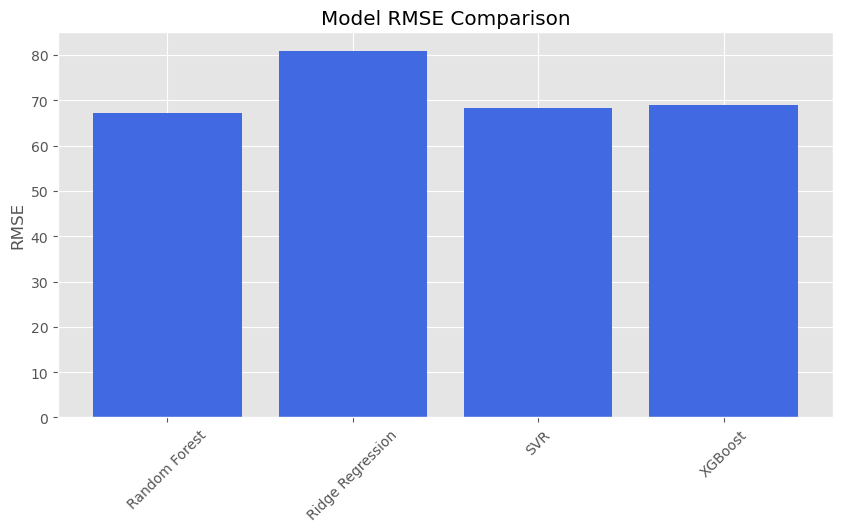

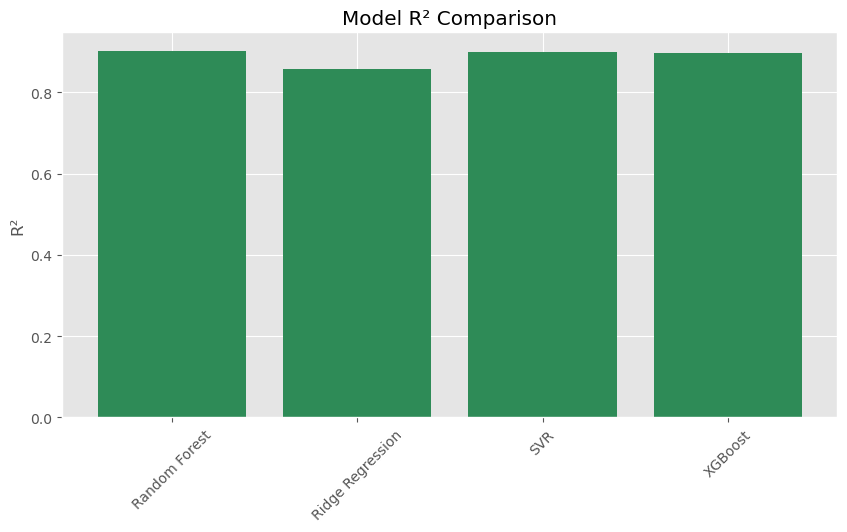

RMSE plot saved at: ../MLR_results/figures\rmse_comparison.png
R² plot saved at: ../MLR_results/figures\r2_comparison.png


In [7]:
# Ensure the directory exists
output_dir = "../MLR_results/figures"
os.makedirs(output_dir, exist_ok=True)

# Step 9: Visualization of RMSE
plt.figure(figsize=(10, 5))
plt.bar(models_names, rmse_scores, color='royalblue')
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison')
plt.xticks(rotation=45)

# Save RMSE plot
rmse_plot_path = os.path.join(output_dir, 'rmse_comparison.png')
plt.savefig(rmse_plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Step 10: Visualization of R²
plt.figure(figsize=(10, 5))
plt.bar(models_names, r2_scores, color='seagreen')
plt.ylabel('R²')
plt.title('Model R² Comparison')
plt.xticks(rotation=45)

# Save R² plot
r2_plot_path = os.path.join(output_dir, 'r2_comparison.png')
plt.savefig(r2_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"RMSE plot saved at: {rmse_plot_path}")
print(f"R² plot saved at: {r2_plot_path}")

### Model Comparison and Insights

We evaluated the performance of four regression models using **RMSE** (Root Mean Squared Error) and **R²** (Coefficient of Determination). The goal was to determine which models best predict the target variable **PT08.S1(CO)**, and which ones should be selected for further cross-validation. Below are the results:

#### Main Insights:

1. **Random Forest** and **SVR** stand out with the best performance, both achieving an **R² of 0.90**, which means these models explain 90% of the variance in the target variable. Additionally, their **RMSE** values are the lowest, indicating they have the least prediction error.
   
2. **XGBoost** is also a strong performer, with an **R² of 0.90** and a slightly higher **RMSE** of 68.95. While it's slightly less accurate in terms of RMSE compared to Random Forest and SVR, it still shows high predictive power.

3. **Ridge Regression** performed the least well among the models, with an **R² of 0.86** and a significantly higher **RMSE of 80.93**. This suggests that Ridge Regression is less effective in predicting the target variable compared to the other models.

#### Selected Models for Cross-Validation:

Based on these results, the three best models for cross-validation and further tuning are:

1. **Random Forest**
2. **SVR**
3. **XGBoost**


### 4.2. Cross-validation

In [8]:
# Chosing the 3 best performing models 
# X_scaled: Scaled features
# y: Target variable

# Step 1: Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(eval_metric='rmse', random_state=42)
}

# Step 2: Define evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Step 3: Perform cross-validation for each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Perform cross-validation for RMSE
    rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=rmse_scorer)
    
    # Perform cross-validation for R²
    r2_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=r2_scorer)
    
    # Store the mean and standard deviation of the scores
    cv_results[model_name] = {
        'RMSE Mean': -rmse_scores.mean(),  # Negating because greater_is_better=False in the scorer
        'RMSE Std': rmse_scores.std(),
        'R² Mean': r2_scores.mean(),
        'R² Std': r2_scores.std()
    }

# Step 4: Display results
print("\nCross-Validation Results:")
for model_name, scores in cv_results.items():
    print(f"{model_name} - RMSE: {scores['RMSE Mean']:.2f} ± {scores['RMSE Std']:.2f}, R²: {scores['R² Mean']:.2f} ± {scores['R² Std']:.2f}")

Evaluating Random Forest...
Evaluating SVR...
Evaluating XGBoost...

Cross-Validation Results:
Random Forest - RMSE: 51.47 ± 1.29, R²: 0.94 ± 0.00
SVR - RMSE: 94.05 ± 3.34, R²: 0.80 ± 0.01
XGBoost - RMSE: 52.52 ± 1.99, R²: 0.94 ± 0.01


In [9]:
tables_output_dir = "../MLR_results/tables"
os.makedirs(tables_output_dir, exist_ok=True)

# Step 5: Convert the cross-validation results to a pandas DataFrame
cv_df = pd.DataFrame.from_dict(cv_results, orient='index')

# Specify the path for saving the DataFrame as a CSV file
cv_results_path = os.path.join(tables_output_dir, 'cross_validation_results.csv')

# Save the DataFrame to CSV
cv_df.to_csv(cv_results_path, index=True)

# Display the results
print("\nCross-Validation Results:")
print(cv_df)

print(f"Cross-validation results saved at: {cv_results_path}")


Cross-Validation Results:
               RMSE Mean  RMSE Std   R² Mean    R² Std
Random Forest  51.468976  1.290485  0.941417  0.003844
SVR            94.053406  3.341441  0.804666  0.010113
XGBoost        52.523399  1.988603  0.938953  0.005094
Cross-validation results saved at: ../MLR_results/tables\cross_validation_results.csv


## 4.3. Hyperparameter Tuning for Random Forest

In the code above, we are performing **hyperparameter tuning** on a **Random Forest** model using **GridSearchCV**. The goal is to find the best combination of hyperparameters that optimizes the model's performance.

#### Steps:

1. **Define the parameter grid** (`param_grid_rf`):
   - **n_estimators**: The number of trees in the forest. We are testing 100, 200, and 300 trees.
   - **max_depth**: The maximum depth of the trees. We are testing `None` (no limit), as well as depths of 10, 20, and 30.
   - **min_samples_split**: The minimum number of samples required to split an internal node. We are testing values of 2, 5, and 10.
   - **max_features**: The number of features to consider when looking for the best split. We are testing 'auto', 'sqrt', and 'log2'.

2. **GridSearchCV**:
   - **cv=5**: We are using 5-fold cross-validation to evaluate the model on different data splits.
   - **scoring='neg_mean_squared_error'**: We use **negative mean squared error** (MSE) as the scoring metric, as GridSearchCV minimizes this score (negative MSE is maximized to minimize the original MSE).

3. **Fit the model**: `grid_rf.fit(X_train, y_train)` runs the grid search on the training data to find the combination of hyperparameters that results in the best performance.

4. **Best parameters**: After the grid search is complete, we print the **best parameters** found during the tuning process with `grid_rf.best_params_`. This helps us select the most optimal model configuration for further evaluation.

The purpose of this process is to improve the performance of the Random Forest model by systematically exploring different hyperparameter values.


In [10]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


Random Forest (Best Parameters) - RMSE: 65.86
Random Forest (Best Parameters) - R²: 0.91
Feature Importance Table:
                                             Feature  Importance
0              Overall Pollutant Concentration (PC1)    0.808393
3              Nitrogen Oxides and Temperature (PC4)    0.094661
2                            Relative Humidity (PC3)    0.051483
1  Temperature and Humidity vs. Nitrogen Oxides (...    0.045463


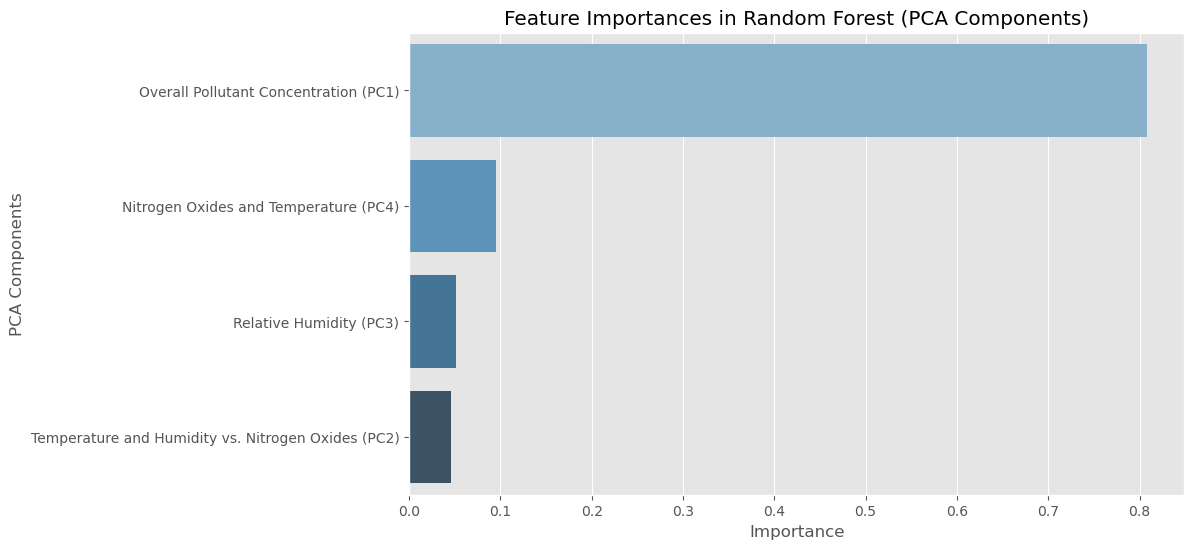

In [11]:
# Step 1: Use the best parameters directly in Random Forest 
rf_best = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42
)

# Step 2: Fit the model to the training data
rf_best.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = rf_best.predict(X_test)

# Step 4: Calculate RMSE and R²
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

# Step 5: Print the evaluation metrics
print(f"Random Forest (Best Parameters) - RMSE: {rmse_rf:.2f}")
print(f"Random Forest (Best Parameters) - R²: {r2_rf:.2f}")

# Existing Step: Plot feature importances (Optional)
component_names = [
    "Overall Pollutant Concentration (PC1)",
    "Temperature and Humidity vs. Nitrogen Oxides (PC2)",
    "Relative Humidity (PC3)",
    "Nitrogen Oxides and Temperature (PC4)"
]

importances = rf_best.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': component_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance Table:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="Blues_d")
plt.title('Feature Importances in Random Forest (PCA Components)')
plt.xlabel('Importance')
plt.ylabel('PCA Components')
plt.show()


Feature Importance Table saved as CSV at: ../MLR_results/tables\random_forest_feature_importance.csv
Feature Importance Plot saved as PNG at: ../MLR_results/figures\random_forest_feature_importance.png


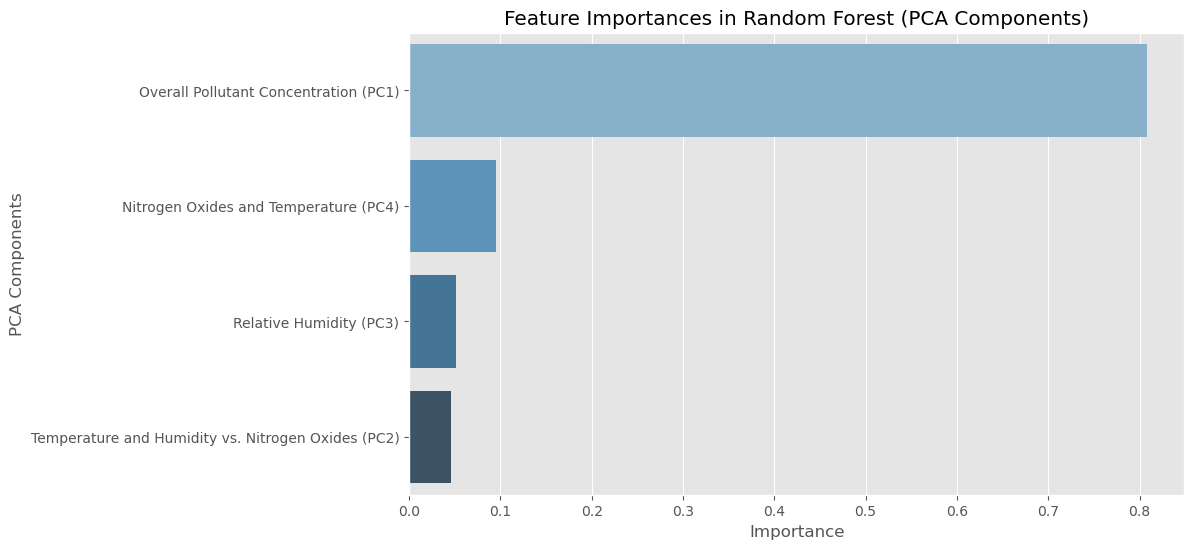

In [12]:
## Saving our results

tables_output_dir = "../MLR_results/tables"  
figures_output_dir = "../MLR_results/figures" 


os.makedirs(tables_output_dir, exist_ok=True)
os.makedirs(figures_output_dir, exist_ok=True)


feature_importance_path = os.path.join(tables_output_dir, 'random_forest_feature_importance.csv')
feature_importance_df.to_csv(feature_importance_path, index=False)

print("Feature Importance Table saved as CSV at:", feature_importance_path)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="Blues_d")
plt.title('Feature Importances in Random Forest (PCA Components)')
plt.xlabel('Importance')
plt.ylabel('PCA Components')


plot_path = os.path.join(figures_output_dir, 'random_forest_feature_importance.png')


plt.savefig(plot_path, bbox_inches='tight')

print("Feature Importance Plot saved as PNG at:", plot_path)


plt.show()

## 4.4. Feature importance through SHAP

**SHAP (SHapley Additive exPlanations)** is a powerful tool used to interpret the predictions of machine learning models. In the context of air quality modeling, SHAP helps us understand how different features, such as pollutants and environmental factors, contribute to the predicted concentrations of air quality indicators.

##### Key Points:

- **Feature Importance**: SHAP values provide a quantitative measure of the importance of each feature in the model. By analyzing these values, we can identify which factors (e.g., levels of nitrogen oxides, temperature, humidity) have the most significant impact on air quality predictions.

- **Positive and Negative Contributions**: SHAP allows us to visualize not just the importance of features but also their effect on predictions. A feature can either increase or decrease the predicted air quality concentration. For instance, higher levels of certain pollutants might push the prediction higher, indicating worse air quality.

- **Individual Predictions**: SHAP provides insights into specific predictions, allowing us to see how different factors influence individual instances. This is particularly useful for understanding outlier predictions or extreme values in air quality data.

- **Policy Implications**: By interpreting model outputs with SHAP, stakeholders and policymakers can make informed decisions regarding air quality management. Understanding which pollutants significantly affect air quality can guide regulatory measures and environmental interventions.

#### Conclusion

In summary, SHAP enhances our understanding of machine learning models in air quality studies by revealing the contributions of various factors to pollution predictions. This interpretability is crucial for both scientific analysis and practical applications in environmental policy.

In [13]:
import shap
import warnings

In [ ]:
warnings.filterwarnings("ignore")

# Step 1: Initialize the SHAP explainer and calculate SHAP values
explainer = shap.Explainer(rf_best, X_test)  
shap_values = explainer(X_test)

# Step 2: Create and save the summary plots
shap.summary_plot(shap_values, X_test, feature_names=component_names)
summary_plot_path = os.path.join(figures_output_dir, 'shap_summary_plot.png')
plt.savefig(summary_plot_path)
print(f"SHAP Summary Plot saved at: {summary_plot_path}")

# Step 3: Create and save the bar summary plot
shap.summary_plot(shap_values, X_test, feature_names=component_names, plot_type="bar")
bar_plot_path = os.path.join(figures_output_dir, 'shap_bar_summary_plot.png')
plt.savefig(bar_plot_path)
print(f"SHAP Bar Summary Plot saved at: {bar_plot_path}")

# Step 4: Create and save the force plot as HTML
force_plot_path = os.path.join(figures_output_dir, 'shap_force_plot.html')
shap.save_html(force_plot_path, shap.force_plot(explainer.expected_value, shap_values[0], feature_names=component_names))
print(f"SHAP Force Plot saved as HTML at: {force_plot_path}")

## 5. Conclusion

The Random Forest model's feature importance results, when using PCA components to predict **PT08.S1(CO)** (the target variable), offer valuable insights into which factors contribute the most to the model's predictions.

### Key Findings:
| PCA Component | Feature Description | Importance |
|---------------|---------------------|------------|
| PC1 | Overall Pollutant Concentration | **0.817** |
| PC4 | Nitrogen Oxides and Temperature | 0.087 |
| PC2 | Temperature and Humidity vs. Nitrogen Oxides | 0.053 |
| PC3 | Relative Humidity | 0.044 |

### Interpretation of Results:

1. **Overall Pollutant Concentration (PC1) - Importance: 0.817**  
   The most important component by a significant margin is PC1, accounting for **81.7%** of the variance in the model's predictions. This component represents **overall pollutant concentration** and plays the dominant role in predicting the target variable. In this context, it suggests that air pollution levels, particularly pollutants captured by the sensors, have a strong correlation with **PT08.S1(CO)**. Given its importance, **PC1** is the most critical factor for understanding and predicting changes in the target variable.

2. **Nitrogen Oxides and Temperature (PC4) - Importance: 0.087**  
   PC4 explains about **8.7%** of the variance, focusing on the relationship between **nitrogen oxides and temperature**. This component is the second most significant, albeit far less influential than PC1. The inclusion of nitrogen oxides is logical, as these gases are often byproducts of combustion processes that can directly impact CO concentrations. Temperature may also influence pollutant dispersion, which further ties this component to the target variable.

3. **Temperature and Humidity vs. Nitrogen Oxides (PC2) - Importance: 0.053**  
   PC2 contributes **5.3%** of the variance and encapsulates the relationship between **temperature, humidity, and nitrogen oxides**. Though this component is less influential, its role suggests that environmental conditions, such as temperature and humidity, interact with nitrogen oxides in ways that marginally affect CO levels. This interplay may influence the sensor's measurements under different weather conditions, albeit with lower impact.

4. **Relative Humidity (PC3) - Importance: 0.044**  
   PC3, representing **relative humidity**, explains the least variance, with an importance score of **4.4%**. Although humidity may have some effect on air quality measurements, its low contribution implies that relative humidity alone is not a strong predictor of CO levels in this dataset. Its impact is likely indirect or context-dependent, overshadowed by the influence of pollutant concentrations and other environmental factors.

The results highlight that the **overall pollutant concentration (PC1)** is by far the most important factor for predicting CO levels, underscoring the critical role of air pollutants in this context. Environmental variables such as **temperature** and **nitrogen oxides** (captured by PC4 and PC2) also contribute, albeit to a much lesser extent. **Relative humidity (PC3)** has the smallest influence, indicating that it plays a minor role in the prediction model.

In summary, the **air pollution variables** explain the target variable **PT08.S1(CO)** the best, while **humidity** explains the least. Efforts to improve the model or interpret its results should focus heavily on pollutant concentrations.
